In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
data = pd.read_csv('univariate_data/realTweets/realTweets/Twitter_volume_IBM.csv')

In [59]:
print(f'data shape : {data.shape}')
data.head()

data shape : (15893, 2)


,timestamp,value
0,2015-02-26 21:42:53,7
1,2015-02-26 21:47:53,4
2,2015-02-26 21:52:53,14
3,2015-02-26 21:57:53,6
4,2015-02-26 22:02:53,1


In [60]:
data.index = pd.to_datetime(data['timestamp'], )
data.drop('timestamp', axis=1, inplace=True)
data.head()

,value
timestamp,
2015-02-26 21:42:53,7
2015-02-26 21:47:53,4
2015-02-26 21:52:53,14
2015-02-26 21:57:53,6
2015-02-26 22:02:53,1


- 5분간격으로 측정
    - 즉, 하루에 12*24번 측정
    - 2월부터 4월까지 측정
    - trend는 없어보이고
    - seasonality고 고려하지 않아도 될듯하다
    - 그냥 arima로 해보자

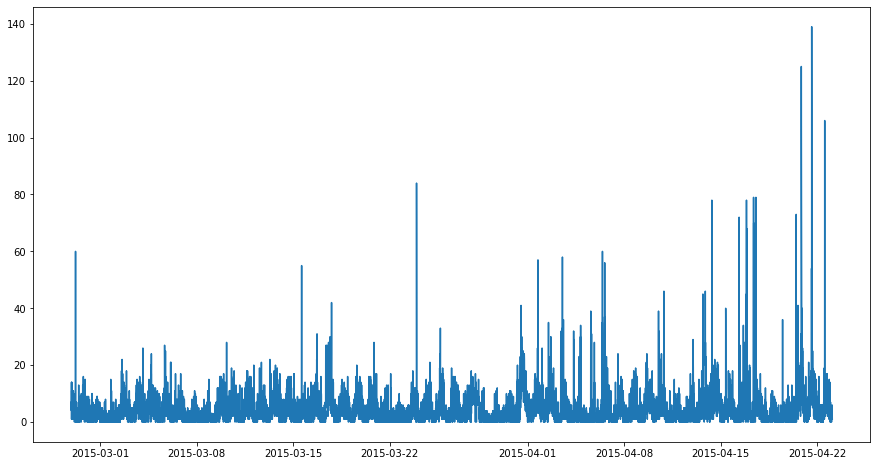

In [80]:
plt.figure(figsize=(15,8))
plt.plot(data['value'])

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split

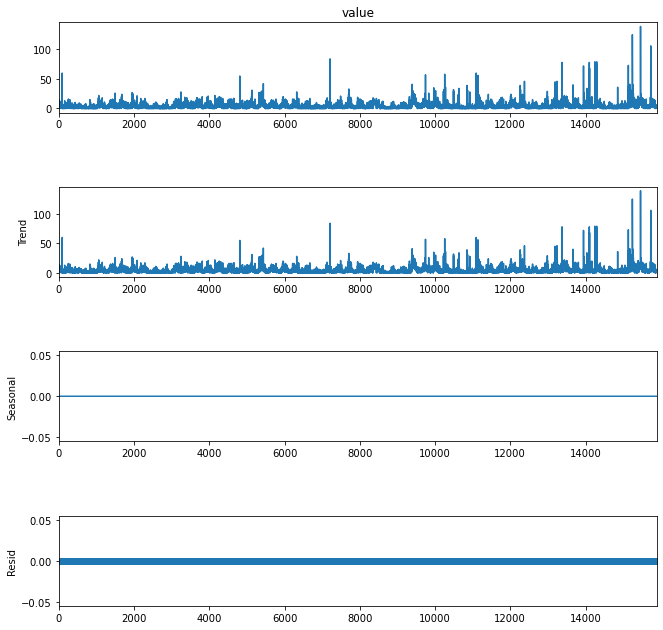

In [20]:
decom = seasonal_decompose(data['value'], period=1)
fig = decom.plot()
fig.set_size_inches(10,10)
plt.show()

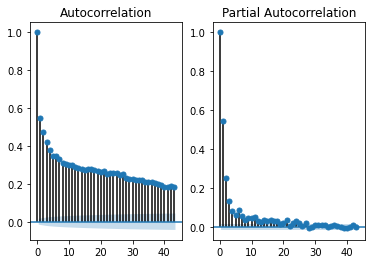

In [27]:
fig, ax = plt.subplots(1,2)
plot_acf(data['value'], ax=ax[0])
plot_pacf(data['value'], ax=ax[1])
plt.show()

# Model Fit

In [63]:
train_data, val_data = train_test_split(data,
                                        train_size= .8,
                                        shuffle=False)

In [41]:
import itertools

p = range(0,4)
d = range(0,3)
q = range(0,4)

pdq = list(itertools.product(p,d,q))

pdqs = []
aics = []
for i in pdq:
    try : 
        model = ARIMA(train_data['value'], order=(i))
        model_fit = model.fit()
        print(f'ARIMA {i} : AIC = {model_fit.aic}')
        pdqs.append(i)
        aics.append(model_fit.aic)
    except:
        continue

ARIMA (0, 0, 0) : AIC = 73952.22346576277
ARIMA (0, 0, 1) : AIC = 71350.593124849
ARIMA (0, 0, 2) : AIC = 70492.81869220725
ARIMA (0, 0, 3) : AIC = 69826.36654464065
ARIMA (0, 1, 0) : AIC = 73353.30184985523
ARIMA (0, 1, 1) : AIC = 68340.12803964346
ARIMA (0, 1, 2) : AIC = 68034.98726899704
ARIMA (0, 1, 3) : AIC = 67994.10926916158
ARIMA (0, 2, 0) : AIC = 86636.09148881641
ARIMA (0, 2, 1) : AIC = 73360.05639598989
ARIMA (0, 2, 2) : AIC = 68351.00484397044
ARIMA (0, 2, 3) : AIC = 68047.17277494151
ARIMA (1, 0, 0) : AIC = 69895.1526757595
ARIMA (1, 0, 1) : AIC = 68198.81678706808
ARIMA (1, 0, 2) : AIC = 67961.15482247056
ARIMA (1, 0, 3) : AIC = 67929.9351005944
ARIMA (1, 1, 0) : AIC = 70860.65930754485
ARIMA (1, 1, 1) : AIC = 67993.46190336338
ARIMA (1, 1, 2) : AIC = 67960.72025178095
ARIMA (1, 1, 3) : AIC = 67962.25045939787
ARIMA (1, 2, 0) : AIC = 80230.80213692423
ARIMA (2, 0, 0) : AIC = 69136.20093055198
ARIMA (2, 0, 1) : AIC = 67929.0394606186
ARIMA (2, 0, 2) : AIC = 67904.673600215

In [42]:
[pdqs[i] for i, j in enumerate(aics) if j == min(aic)]

[(2, 0, 2)]

In [44]:
best_model = ARIMA(train_data['value'], order=(2,0,2))
best_model_fit = best_model.fit()

best_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                12714
Model:                     ARMA(2, 2)   Log Likelihood              -33946.337
Method:                       css-mle   S.D. of innovations              3.494
Date:                Wed, 24 Feb 2021   AIC                          67904.674
Time:                        00:41:29   BIC                          67949.376
Sample:                             0   HQIC                         67919.626
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.1469      0.333     12.453      0.000       3.494       4.800
ar.L1.value     1.4457      0.044     32.733      0.000       1.359       1.532
ar.L2.value    -0.4517      0.044    -10.384      0.000      -0.537      -0.366
ma.L1.value    -1.1711      0.047    -25.049      0.000      -1.263      -1.080
ma.L2.value     0.2369      0.040      5.850      0.000       0.158       0.316
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0113           +0.0000j            1.0113            0.0000
AR.2            2.1889           +0.0000j            2.1889            0.0000
MA.1            1.0976           +0.0000j            1.0976            0.0000
MA.2            3.8455           +0.0000j            3.8455            0.0000
-----------------------------------------------------------------------------
"""

# Forecast

In [88]:
pred = best_model_fit.forecast(len(val_data))
pred_value = pred[0]
pred_ub = pred[2][:, 0]
pred_lb = pred[2][:, 1]

val_index = val_data.index

In [89]:
val_data

,value
timestamp,
2015-04-12 01:12:53,3
2015-04-12 01:17:53,1
2015-04-12 01:22:53,1
2015-04-12 01:27:53,3
2015-04-12 01:32:53,1
...,...
2015-04-23 01:42:53,6
2015-04-23 01:47:53,5
2015-04-23 01:52:53,2


In [90]:
val_data['value']

timestamp
2015-04-12 01:12:53    3
2015-04-12 01:17:53    1
2015-04-12 01:22:53    1
2015-04-12 01:27:53    3
2015-04-12 01:32:53    1
                      ..
2015-04-23 01:42:53    6
2015-04-23 01:47:53    5
2015-04-23 01:52:53    2
2015-04-23 01:57:53    2
2015-04-23 02:02:53    1
Name: value, Length: 3179, dtype: int64

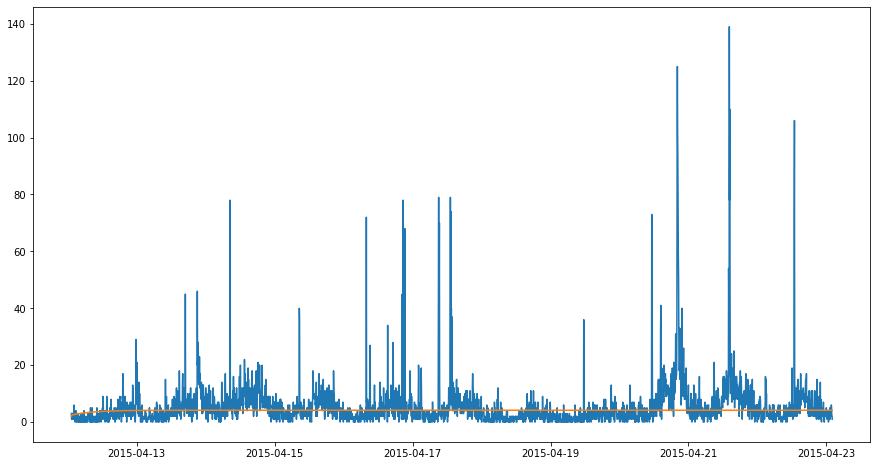

In [116]:
plt.figure(figsize=(15,8))
plt.plot(val_data['value'])
plt.plot(val_index,pred_value)

# Anomaly detection using error
- error is Gaussian

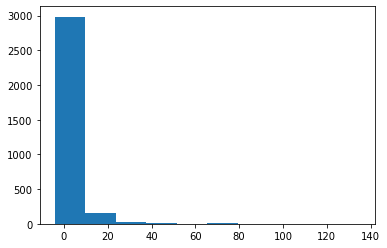

In [96]:
error = val_data['value'] - pred_value
plt.hist(error)
plt.show()

In [99]:
error_mean = np.mean(error)
error_std = np.std(error)

print(f'lower bound : {error_mean - 3*error_std}')
print(f'higher bound : {error_mean + 3*error_std}')

lower bound : -24.010318927715836
higher bound : 26.594300946492154


In [115]:
higher_bound = error_mean + 3*error_std
anomaly = list(val_data['value'] > higher_bound)
print(f'how many anomaly counts : {np.sum(anomaly)} in {len(val_data)}')

how many anomaly counts : 49 in 3179


In [119]:
# for Vis
x = val_index[anomaly]
y = val_data['value'][anomaly]

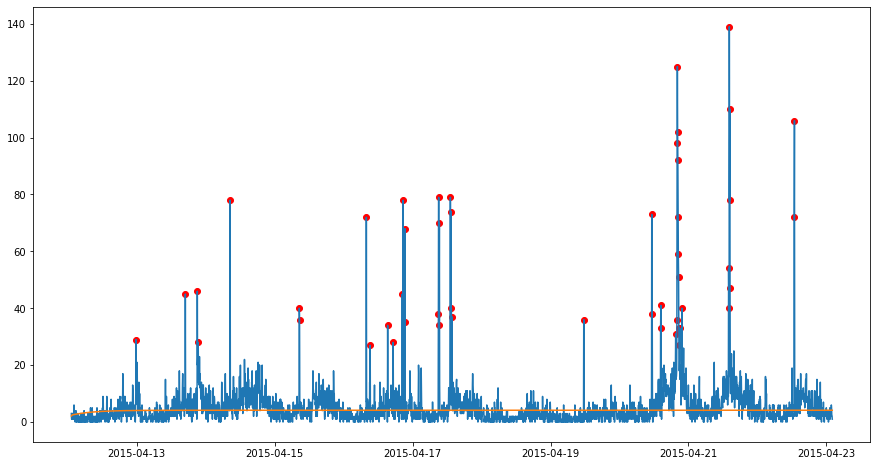

In [121]:
plt.figure(figsize=(15,8))
plt.plot(val_data['value'])
plt.plot(val_index,pred_value)
plt.scatter(x, y, color='red')

# End